In [4]:
#Import libraries

from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime.fake_provider import FakeLagosV2 , FakePerth, FakeBelemV2, FakeValenciaV2, FakeRomeV2, FakeOslo
import qiskit.visualization as vs

import numpy as np
import matplotlib.pyplot as plt
import pylatexenc as py
import math
from itertools import combinations
import seaborn as sns
import pandas as pd

from sklearn.preprocessing import StandardScaler

In [5]:
#Controll Cell
shots = 20000
num_samples = 500
measured_qubits = 2

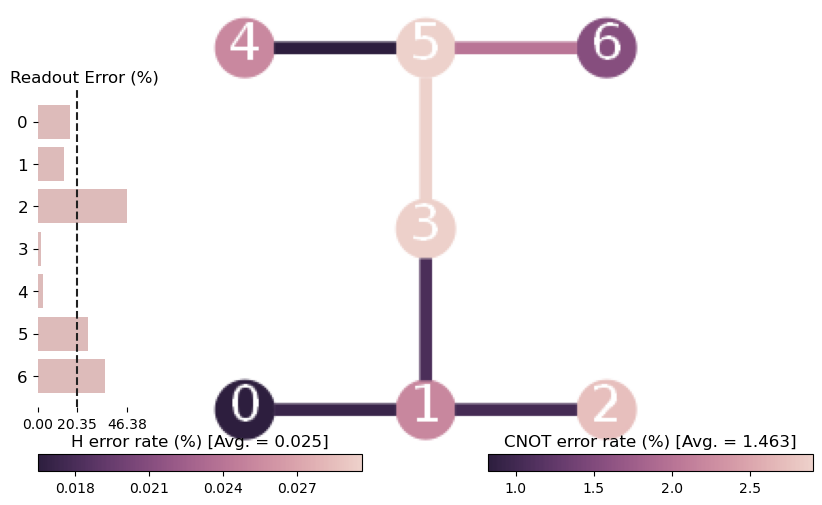

In [7]:
vs.plot_error_map(  FakeLagosV2() , figsize=(10, 6), show_title=False, qubit_coordinates=None)

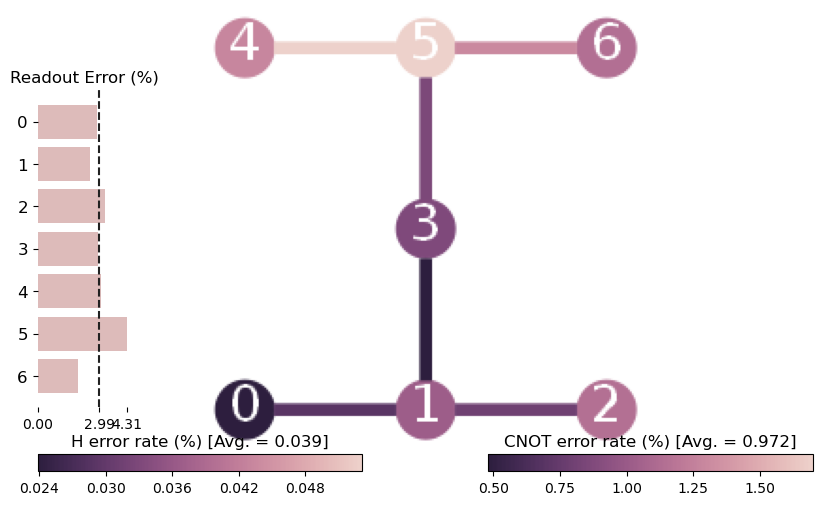

In [8]:
vs.plot_error_map(  FakePerth() , figsize=(10, 6), show_title=False, qubit_coordinates=None)

In [ ]:
#Quantum Circuit
qc = QuantumCircuit(7,2)

qc.h(3)
qc.ry( np.pi/3 , 3)
qc.cx(3,5)
qc.h(5)
qc.cx(5,4)
qc.h(4)
qc.ry(2*np.pi/3, 4)

qc.measure([3,4],[0,1])

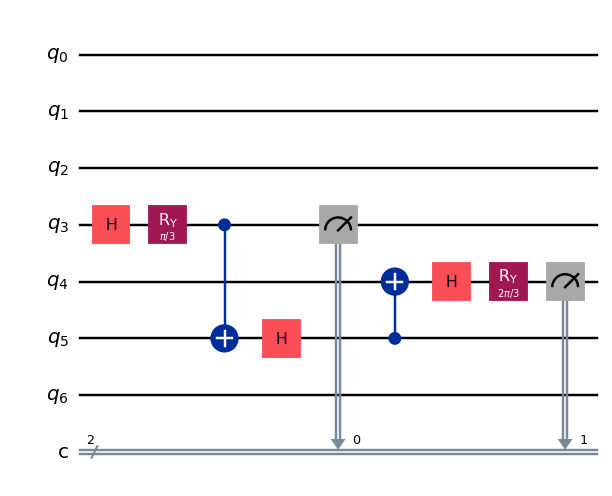

In [ ]:
style = {'dpi': 200, 'figwidth': 6, 'figheight': 4}
vs.circuit_drawer(qc , output= 'mpl', style = style )

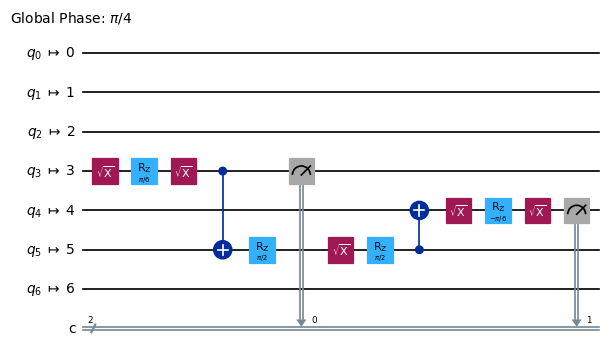

In [ ]:
t_qc = transpile( qc, FakeLagosV2())
vs.circuit_drawer( t_qc , output= 'mpl', style = style )

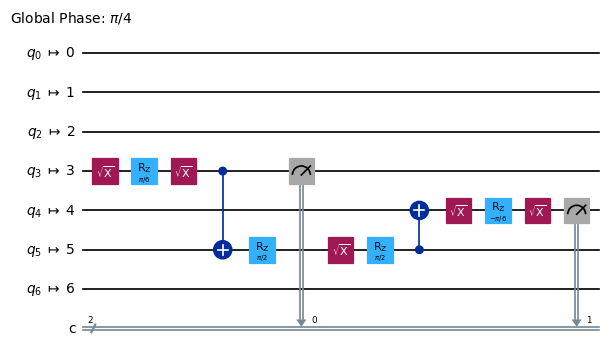

In [ ]:
t_qc1 = transpile( qc, FakePerth())
vs.circuit_drawer( t_qc1 , output= 'mpl', style = style )

In [ ]:
Backend_list= {
    'Lagos'    : FakeLagosV2(),
    'Perth'    : FakePerth(),
}

In [ ]:
# Function for run our quantum circuit on a backend
 
def run_circuit(circuit, backend, shots, measured_qubits ):
    
# transpile the circuit for the backend
    transpiled_circuit = transpile(circuit, backend) 

# run the transpile circuit on the backend 
    job = backend.run(transpiled_circuit, shots = shots)

# get the result counts
    counts = job.result().get_counts()

# define all_possible_keys in order to convert natural number in range 2^(number of measured qubit) in binary number
    # exemple: measured_qubit = 2; [ 1,2,3,4] --> [00 , 01 , 10 , 11 ]
    all_possible_keys = [format(i, '0'+str(measured_qubits)+'b') for i in range(2**measured_qubits)]

# Let's normalize the counts in order to have values in range [0,1]. Additionally, let's add the keys with no counts, assigning them a value of 0
    for key in all_possible_keys:
        if key not in counts:
            counts[key] = 0.0
        counts[key] = counts[key]/shots
    sorted_counts = dict(sorted(counts.items()))
    return sorted_counts

In [ ]:
# Function for create an array with counts get by 'run_circuit'

def make_counts_array( num_samples , circuit , backend, shots, measured_qubits):
    
# preallocate a matrix with dimention [num_samples] x [ 2^(measured_qubit) ]
    data = np.zeros((num_samples , 2**measured_qubits))
    
    for i in range( num_samples):
        
        # preallocate the array for the counts
        counts_array = np.zeros(2**measured_qubits)
        counts = run_circuit(circuit, backend, shots, measured_qubits)
        
        # fill the count_array
        for j, key in enumerate(sorted(counts.keys())):
            counts_array[j] = counts[key]
        data[i] = counts_array
    return data

In [ ]:
# Function to create a dataset and a labels

def make_dataset(num_samples, circuit, backend1, backend2, shots, measured_qubits):
    
# preallocate a dataset with dimention [2num_samples] x [ 2^(measured_qubit) ]
    dataset = np.zeros((2*num_samples, 2**measured_qubits))
    
    # generate samples calling the function 'make_counts_array' using backend1 as input
    data1 = make_counts_array( num_samples, circuit, backend1, shots, measured_qubits)
    
    # generate samples calling the function 'make_counts_array' using backend1 as input
    data2 = make_counts_array( num_samples, circuit, backend2, shots, measured_qubits)

    # Concatenate data1 and data2
    dataset = np.concatenate([data1,data2])
    
    # create the labels: 0 for samples of backend1, 1 for samples of backend2
    labels = np.concatenate([np.zeros(num_samples), np.ones(num_samples)])
    
    # return the dataset and the labels
    return dataset, labels

In [ ]:
#Generate the dataset and the labels. Save them in 2 different file.npy 

keys = list(Backend_list.keys())
for combination in combinations(keys,2):
    key1, key2 = combination
    file_name   = 'Dati/dataset_{}_x_{}'.format( key1 , key2) 
    labels_name = 'Dati/labels_{}_x_{}'.format( key1 , key2)
    dataset, labels = make_dataset(num_samples, qc , Backend_list[key1], Backend_list[key2], shots, measured_qubits)

    normalized_dataset = StandardScaler().fit_transform(dataset)
    np.save(file_name , normalized_dataset)
    np.save(labels_name, labels)

c:\Users\admin\anaconda3\envs\qiskit-env\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


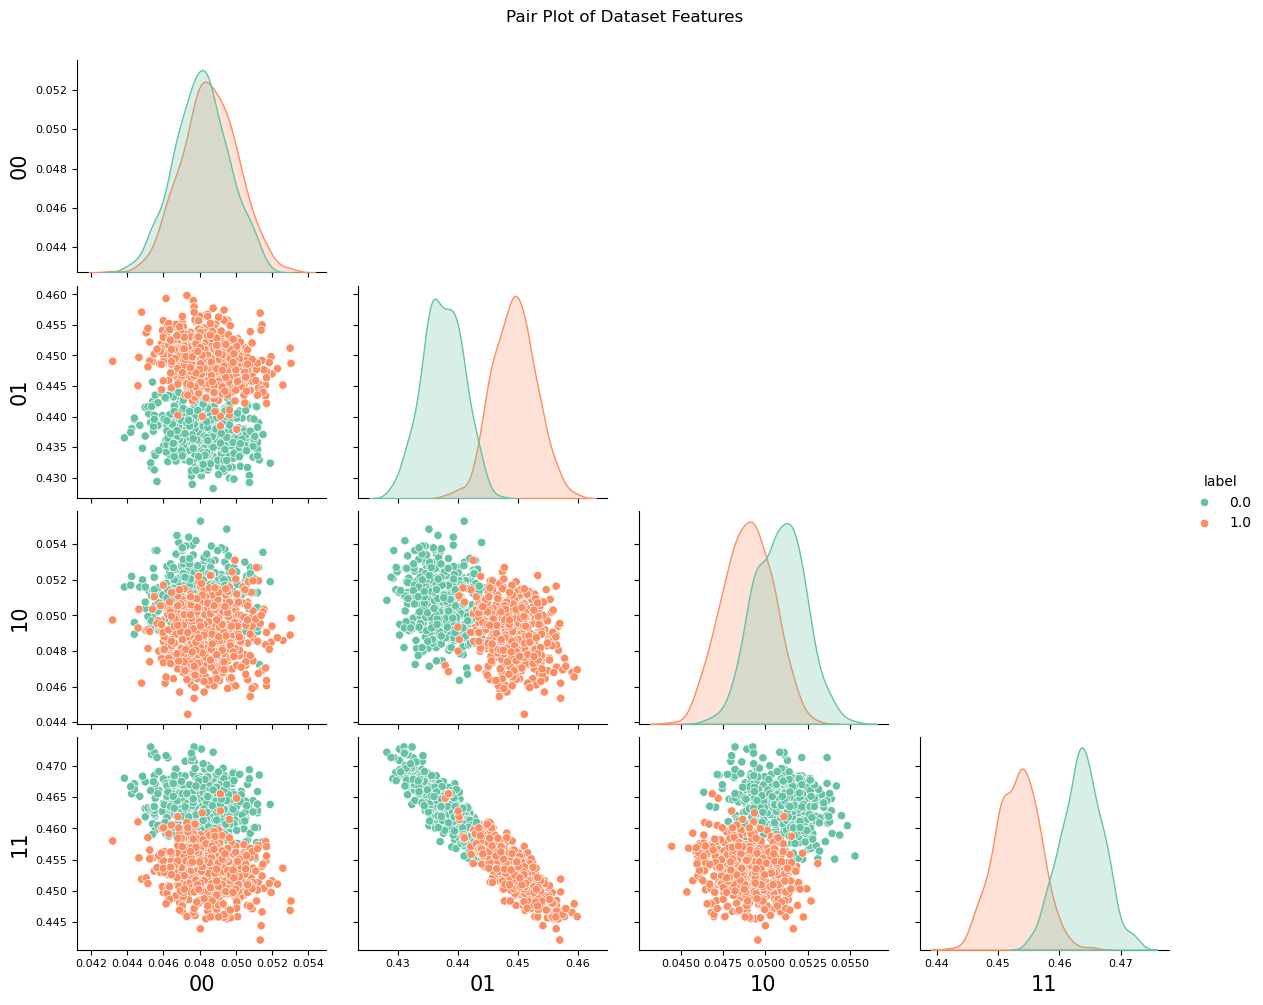

<Figure size 640x480 with 0 Axes>

In [ ]:
df = pd.DataFrame(dataset)
df['label'] = labels

pair_plot = sns.pairplot(df, hue='label', markers=["o", "o"], palette='Set2', diag_kind='kde', height=2.5, aspect= 1.2)

pair_plot.fig.suptitle("Pair Plot of Dataset Features", y=1.0)

bases = [format(i, '0'+str(measured_qubits)+'b') for i in range(2**measured_qubits)]

for i, j in zip(*np.tril_indices_from(pair_plot.axes, -1)):
    pair_plot.axes[j, i].set_visible(False)

i = 0
for ax in pair_plot.axes.flatten():
    ax.set_xlabel( bases[ i%4 ] , fontsize = 15 ) 
    ax.set_ylabel( bases[ int(i/4) ] , fontsize = 15 )
    ax.tick_params(axis='both', which='major', labelsize=8)
    i += 1

plt.subplots_adjust(top=0.95)
plt.show()

keys = list(Backend_list.keys())
for combination in combinations(keys,2):
    key1, key2 = combination
    file_name   = 'Grafici/pairplot_{}_x_{}.png'.format( key1 , key2) 
    plt.savefig(file_name )
    